In [0]:
## Import required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import warnings
warnings.simplefilter("ignore")

In [3]:
## Initializing dask for parallel computing
from dask.distributed import Client, progress
# if __name__ == "__main__":
# client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36857 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 13.65 GB


In [4]:
### Used to view the Dask dashboard in Google Colab
## Comment out if not required
# ! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 8787 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://21c54fc80716.ngrok.io


In [0]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [0]:
df_pic_pr = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id == 'piControl' & variable_id=='pr'")
df_x4_pr = df.query("activity_id=='CMIP' & table_id=='day' & experiment_id == 'abrupt-4xCO2' & variable_id=='pr'")

In [7]:
df_x4_pr.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
8836,CMIP,CCCma,CanESM5,abrupt-4xCO2,r1i1p1f1,day,pr,gn,gs://cmip6/CMIP/CCCma/CanESM5/abrupt-4xCO2/r1i...,NaN
16880,CMIP,CNRM-CERFACS,CNRM-CM6-1-HR,abrupt-4xCO2,r1i1p1f2,day,pr,gr,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/abr...,NaN
17154,CMIP,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,r1i1p1f2,day,pr,gr,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-CM6-1/abrupt...,NaN
21433,CMIP,CNRM-CERFACS,CNRM-ESM2-1,abrupt-4xCO2,r1i1p1f2,day,pr,gr,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/abrup...,NaN
25430,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,abrupt-4xCO2,r1i1p1f1,day,pr,gr,gs://cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-...,NaN


In [8]:
df_x4_pr.groupby(['source_id'])['zstore'].count()

source_id
CESM2              1
CESM2-WACCM        1
CNRM-CM6-1         1
CNRM-CM6-1-HR      1
CNRM-ESM2-1        1
CanESM5            1
EC-Earth3-Veg      1
GFDL-CM4           2
GFDL-ESM4          1
HadGEM3-GC31-LL    1
IPSL-CM6A-LR       1
MIROC6             1
MRI-ESM2-0         1
SAM0-UNICON        1
UKESM1-0-LL        1
Name: zstore, dtype: int64

In [9]:
common_models = list(set(df_x4_pr['source_id']) & set(df_pic_pr['source_id']))
common_models

['CanESM5',
 'CESM2-WACCM',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'CNRM-ESM2-1',
 'MIROC6',
 'CNRM-CM6-1',
 'EC-Earth3-Veg',
 'CNRM-CM6-1-HR',
 'UKESM1-0-LL',
 'CESM2',
 'HadGEM3-GC31-LL',
 'MRI-ESM2-0']

In [0]:
def get_data(df_psl, source_id):
  '''
  1) Loads data using zarr from Google cloud 
  2) combines historical with ssp245
  '''
  uri = df_psl[(df_psl.source_id == source_id)].zstore.values[0]
  gcs = gcsfs.GCSFileSystem(token='anon')
  ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
  return ds

def get_lon(val):
    '''
    Converts data to 180W to 180E longitude format
    '''
    lon=(((val.lon + 180) % 360) - 180)
    val.coords['lon']=lon
    val = val.sortby(val.lon)
    return val

def get_dpr(df_pic_pr,df_x4_pr,model):
  pr_pic = get_data(df_pic_pr, model)['pr']
  pr_x4 = get_data(df_x4_pr, model)['pr']
  pic_pr_mean = pr_pic[:18250].mean(dim='time').load()
  x4_pr_mean = pr_pic[-18250:].mean(dim='time').load()
  d_pr = ((x4_pr_mean-pic_pr_mean)*86400)
  return d_pr

In [0]:
dpr = get_dpr(df_pic_pr,df_x4_pr,common_models[1])

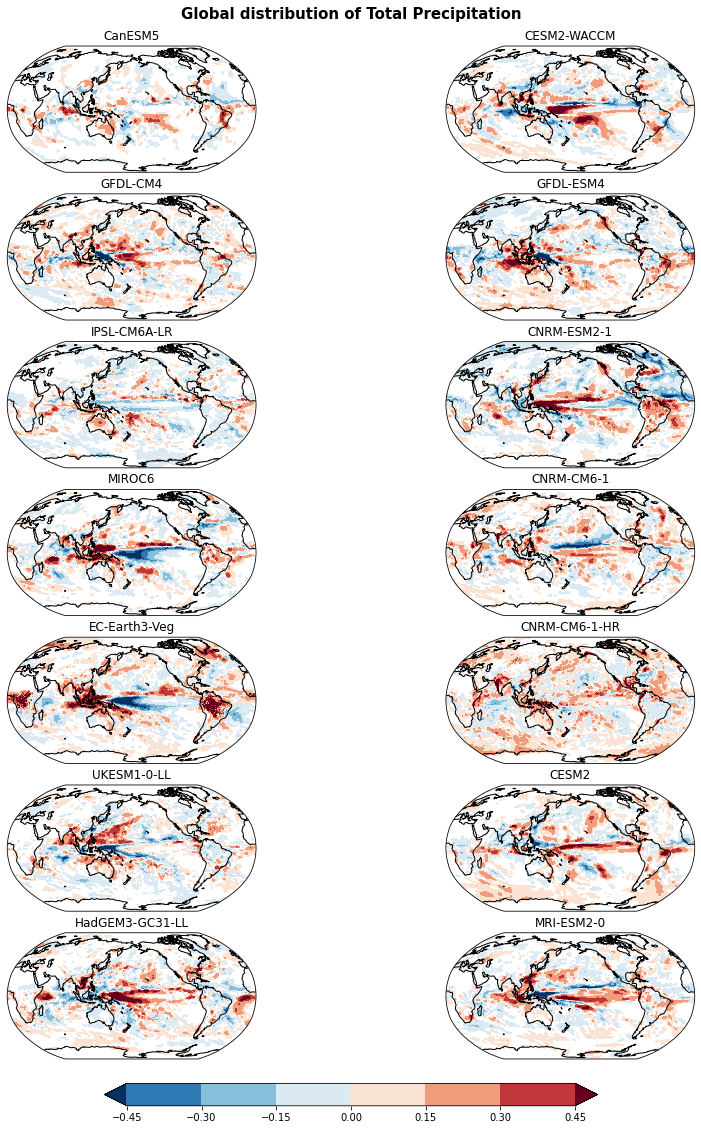

In [261]:
## Plotting total precip change
proj = ccrs.Robinson(central_longitude = 180)
fig, axs = plt.subplots(7,2,figsize=[14,18],subplot_kw=dict(projection=proj))
fig.suptitle('Global distribution of Total Precipitation',fontsize=15,weight='bold')
clevs = [-.75,-.5,-.25,-.1,.1,.25,.5,.75]
m = 0
n = 0
for i in range(0,14):
  dpr = get_dpr(df_pic_pr,df_x4_pr,common_models[i])
  d_pr = dpr.where((dpr<-0.05) | (dpr>.05))
  a = d_pr.plot.contourf(ax=axs[n,m], robust=True, level=clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r',extend='both',add_colorbar=False,vmin=-.45,vmax=.45)
  # plt.contourf(d_pr.lon,d_pr.lat,d_pr,robust=True, transform=ccrs.PlateCarree(), cmap='bwr',extend='both')
  axs[n,m].coastlines()
  axs[n,m].set_global()
  axs[n,m].set_title(common_models[i])
  m=m+1
  if m>1:
    m=0
    n=n+1
  else:
    continue
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.colorbar(a,ax=axs.ravel().tolist(),orientation='horizontal',pad=0.02, shrink=0.5)

In [0]:
# fig.savefig("spatial_pr.eps", format='eps', dpi=350, bbox_inches='tight',pad_inches=0.1)
# from google.colab import files
# files.download("spatial_pr.eps")